<a href="https://colab.research.google.com/github/ThierrryScotto/Ocorrencias-Criminais---Sinesp/blob/master/Robbery_forecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importing the libraries

In [2]:
import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
from statsmodels.tsa.seasonal import STL, seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Getting the data

In [5]:
# dataset = pd.read_excel('indicadoressegurancapublicauf.xlsx')
dataset = pd.read_excel('/content/indicadoressegurancapublicauf.xlsx')
dataset.head(5)

,UF,Tipo Crime,Ano,Mês,Ocorrências
0,Acre,Estupro,2022,janeiro,31
1,Acre,Furto de veículo,2022,janeiro,50
2,Acre,Homicídio doloso,2022,janeiro,10
3,Acre,Lesão corporal seguida de morte,2022,janeiro,1
4,Acre,Roubo a instituição financeira,2022,janeiro,0


In [6]:
dataset.rename(columns={
  'UF': 'State',
  'Tipo Crime': 'Crimes',
  'Ano': 'Year',
  'Mês': 'Month',
  'Ocorrências': 'Occurrences'
  }, inplace=True)

dataset.columns

Index(['State', 'Crimes', 'Year', 'Month', 'Occurrences'], dtype='object')

# Data Preparation

In [7]:
STATE = 'São Paulo'

In [8]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23020 entries, 0 to 23019
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   State        23020 non-null  object
 1   Crimes       23020 non-null  object
 2   Year         23020 non-null  int64 
 3   Month        23020 non-null  object
 4   Occurrences  23020 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 899.3+ KB


In [9]:
dataset.shape

(23020, 5)

In [10]:
dataset.columns

Index(['State', 'Crimes', 'Year', 'Month', 'Occurrences'], dtype='object')

In [11]:
dataset.isnull().sum()

State          0
Crimes         0
Year           0
Month          0
Occurrences    0
dtype: int64

In [12]:
dataset_bank_robbery   = dataset[dataset['Crimes'] == 'Roubo a instituição financeira']
dataset_cargo_theft    = dataset[dataset['Crimes'] == 'Roubo de carga']
dataset_vehicle_theft  = dataset[dataset['Crimes'] == 'Roubo de veículo']
dataset_robbery_murder = dataset[dataset['Crimes'] == 'Roubo seguido de morte (latrocínio)']

In [13]:
concat_dataset = pd.concat([dataset_bank_robbery,
                          dataset_cargo_theft,
                          dataset_vehicle_theft,
                          dataset_robbery_murder], ignore_index=True)

concat_dataset

,State,Crimes,Year,Month,Occurrences
0,Acre,Roubo a instituição financeira,2022,janeiro,0
1,Acre,Roubo a instituição financeira,2022,fevereiro,0
2,Acre,Roubo a instituição financeira,2022,março,0
3,Alagoas,Roubo a instituição financeira,2022,janeiro,0
4,Alagoas,Roubo a instituição financeira,2022,fevereiro,0
...,...,...,...,...,...
10124,Tocantins,Roubo seguido de morte (latrocínio),2015,agosto,1
10125,Tocantins,Roubo seguido de morte (latrocínio),2015,setembro,0
10126,Tocantins,Roubo seguido de morte (latrocínio),2015,outubro,1
10127,Tocantins,Roubo seguido de morte (latrocínio),2015,novembro,0


In [14]:
concat_dataset['Crimes'].unique()

array(['Roubo a instituição financeira', 'Roubo de carga',
       'Roubo de veículo', 'Roubo seguido de morte (latrocínio)'],
      dtype=object)

In [15]:
concat_dataset[concat_dataset['State'] == STATE]

,State,Crimes,Year,Month,Occurrences
250,São Paulo,Roubo a instituição financeira,2022,janeiro,1
251,São Paulo,Roubo a instituição financeira,2022,fevereiro,1
252,São Paulo,Roubo a instituição financeira,2022,março,1
253,São Paulo,Roubo a instituição financeira,2022,abril,2
254,São Paulo,Roubo a instituição financeira,2022,maio,1
...,...,...,...,...,...
10100,São Paulo,Roubo seguido de morte (latrocínio),2015,agosto,29
10101,São Paulo,Roubo seguido de morte (latrocínio),2015,setembro,21
10102,São Paulo,Roubo seguido de morte (latrocínio),2015,outubro,39
10103,São Paulo,Roubo seguido de morte (latrocínio),2015,novembro,26


In [16]:
state_dataset = concat_dataset[concat_dataset['State'] == STATE]
state_dataset.head(5)

,State,Crimes,Year,Month,Occurrences
250,São Paulo,Roubo a instituição financeira,2022,janeiro,1
251,São Paulo,Roubo a instituição financeira,2022,fevereiro,1
252,São Paulo,Roubo a instituição financeira,2022,março,1
253,São Paulo,Roubo a instituição financeira,2022,abril,2
254,São Paulo,Roubo a instituição financeira,2022,maio,1


In [17]:
state_dataset.loc[:,'State'] = 'SP'
state_dataset

<ipython-input-17-44f5c8d7486f>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  state_dataset.loc[:,'State'] = 'SP'


,State,Crimes,Year,Month,Occurrences
250,SP,Roubo a instituição financeira,2022,janeiro,1
251,SP,Roubo a instituição financeira,2022,fevereiro,1
252,SP,Roubo a instituição financeira,2022,março,1
253,SP,Roubo a instituição financeira,2022,abril,2
254,SP,Roubo a instituição financeira,2022,maio,1
...,...,...,...,...,...
10100,SP,Roubo seguido de morte (latrocínio),2015,agosto,29
10101,SP,Roubo seguido de morte (latrocínio),2015,setembro,21
10102,SP,Roubo seguido de morte (latrocínio),2015,outubro,39
10103,SP,Roubo seguido de morte (latrocínio),2015,novembro,26


### Converting month from str to int

In [18]:
state_dataset['Month'].unique()

array(['janeiro', 'fevereiro', 'março', 'abril', 'maio', 'junho', 'julho',
       'agosto', 'setembro', 'outubro', 'novembro', 'dezembro'],
      dtype=object)

In [19]:
month_dic = {
 'janeiro': 1,
 'fevereiro': 2,
 'março': 3,
 'abril': 4,
 'maio': 5,
 'junho': 6,
 'julho': 7,
 'agosto': 8,
 'setembro': 9,
 'outubro': 10,
 'novembro': 11,
 'dezembro': 12
}

In [20]:
state_dataset['Month'] = state_dataset['Month'].map(month_dic)
state_dataset['Month']

<ipython-input-20-2e246715cfb7>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  state_dataset['Month'] = state_dataset['Month'].map(month_dic)


250       1
251       2
252       3
253       4
254       5
         ..
10100     8
10101     9
10102    10
10103    11
10104    12
Name: Month, Length: 384, dtype: int64

In [21]:
sorted_dataset = state_dataset.sort_values(by=['Year', 'Month'])
sorted_dataset.tail(12)

,State,Crimes,Year,Month,Occurrences
259,SP,Roubo a instituição financeira,2022,10,1
2770,SP,Roubo de carga,2022,10,508
5264,SP,Roubo de veículo,2022,10,3945
7839,SP,Roubo seguido de morte (latrocínio),2022,10,11
260,SP,Roubo a instituição financeira,2022,11,0
2771,SP,Roubo de carga,2022,11,550
5265,SP,Roubo de veículo,2022,11,4107
7840,SP,Roubo seguido de morte (latrocínio),2022,11,17
261,SP,Roubo a instituição financeira,2022,12,2
2772,SP,Roubo de carga,2022,12,588


In [22]:
sorted_dataset = sorted_dataset.copy()
sorted_dataset['Crimes'] = 'robbery'
sorted_dataset['Crimes'].head(5)

2465     robbery
4932     robbery
7522     robbery
10093    robbery
2466     robbery
Name: Crimes, dtype: object

In [23]:
sorted_dataset

,State,Crimes,Year,Month,Occurrences
2465,SP,robbery,2015,1,17
4932,SP,robbery,2015,1,782
7522,SP,robbery,2015,1,7490
10093,SP,robbery,2015,1,33
2466,SP,robbery,2015,2,17
...,...,...,...,...,...
7840,SP,robbery,2022,11,17
261,SP,robbery,2022,12,2
2772,SP,robbery,2022,12,588
5266,SP,robbery,2022,12,4423


In [24]:
sorted_dataset.drop(columns=['State', 'Crimes'], inplace=True)

In [25]:
sorted_dataset

,Year,Month,Occurrences
2465,2015,1,17
4932,2015,1,782
7522,2015,1,7490
10093,2015,1,33
2466,2015,2,17
...,...,...,...
7840,2022,11,17
261,2022,12,2
2772,2022,12,588
5266,2022,12,4423


In [26]:
grouped_df = sorted_dataset.groupby(by=['Year', 'Month'], as_index=False).sum()
grouped_df

,Year,Month,Occurrences
0,2015,1,8322
1,2015,2,7248
2,2015,3,7792
3,2015,4,7392
4,2015,5,6949
...,...,...,...
91,2022,8,3556
92,2022,9,3773
93,2022,10,4465
94,2022,11,4674


## Creating date column

In [27]:
grouped_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96 entries, 0 to 95
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   Year         96 non-null     int64
 1   Month        96 non-null     int64
 2   Occurrences  96 non-null     int64
dtypes: int64(3)
memory usage: 2.4 KB


In [28]:
dates = []
for index in range(len(grouped_df)):
    dates.append(f"{grouped_df['Year'][index]}-{grouped_df['Month'][index]}")

print(dates)

['2015-1', '2015-2', '2015-3', '2015-4', '2015-5', '2015-6', '2015-7', '2015-8', '2015-9', '2015-10', '2015-11', '2015-12', '2016-1', '2016-2', '2016-3', '2016-4', '2016-5', '2016-6', '2016-7', '2016-8', '2016-9', '2016-10', '2016-11', '2016-12', '2017-1', '2017-2', '2017-3', '2017-4', '2017-5', '2017-6', '2017-7', '2017-8', '2017-9', '2017-10', '2017-11', '2017-12', '2018-1', '2018-2', '2018-3', '2018-4', '2018-5', '2018-6', '2018-7', '2018-8', '2018-9', '2018-10', '2018-11', '2018-12', '2019-1', '2019-2', '2019-3', '2019-4', '2019-5', '2019-6', '2019-7', '2019-8', '2019-9', '2019-10', '2019-11', '2019-12', '2020-1', '2020-2', '2020-3', '2020-4', '2020-5', '2020-6', '2020-7', '2020-8', '2020-9', '2020-10', '2020-11', '2020-12', '2021-1', '2021-2', '2021-3', '2021-4', '2021-5', '2021-6', '2021-7', '2021-8', '2021-9', '2021-10', '2021-11', '2021-12', '2022-1', '2022-2', '2022-3', '2022-4', '2022-5', '2022-6', '2022-7', '2022-8', '2022-9', '2022-10', '2022-11', '2022-12']


In [29]:
grouped_df['Date'] = pd.to_datetime(dates)
grouped_df.set_index('Date', inplace=True)
grouped_df.sort_index()
grouped_df

,Year,Month,Occurrences
Date,,,
2015-01-01,2015,1,8322
2015-02-01,2015,2,7248
2015-03-01,2015,3,7792
2015-04-01,2015,4,7392
2015-05-01,2015,5,6949
...,...,...,...
2022-08-01,2022,8,3556
2022-09-01,2022,9,3773
2022-10-01,2022,10,4465


# Time Series analysis

In [30]:
def plot_dataset(x, y, x_label, y_label, title, figsize=(12,10), dpi=90):
  plt.figure(figsize=figsize, dpi=90)
  plt.plot(x, y)
  plt.xlabel(x_label)
  plt.ylabel(y_label)
  plt.title(title)
  plt.show()

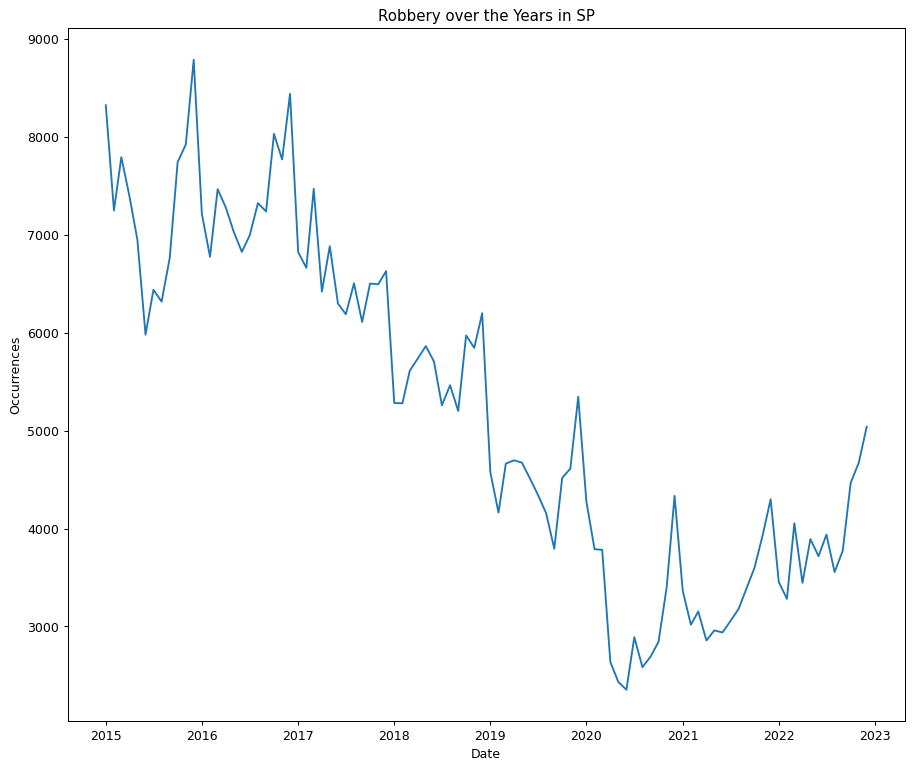

In [32]:
plot_dataset(grouped_df.index, grouped_df['Occurrences'], 'Date', 'Occurrences', 'Robbery over the Years in SP')

### Plotting occurrences by month and year

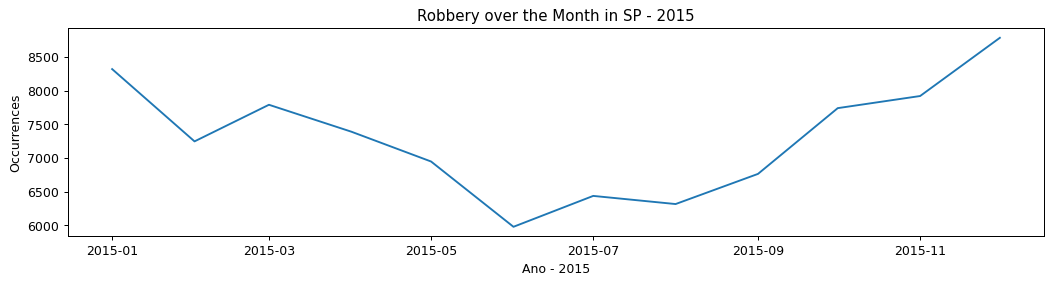

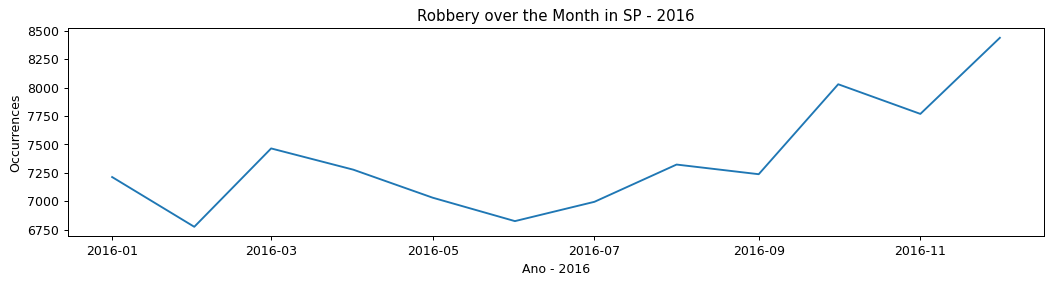

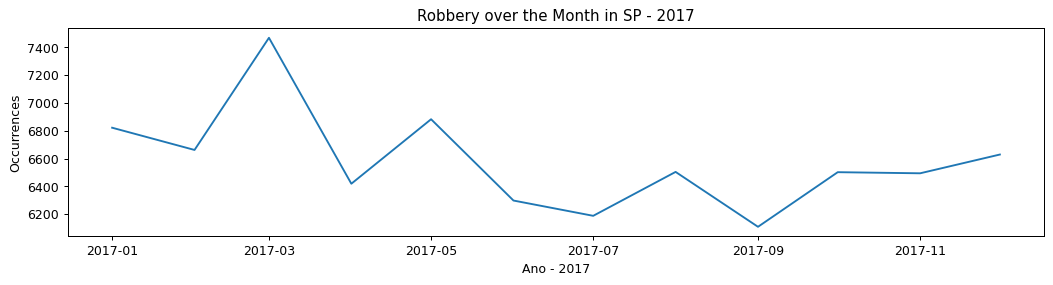

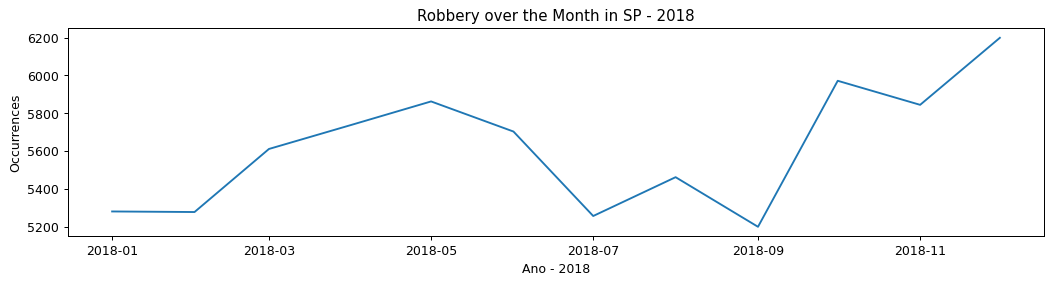

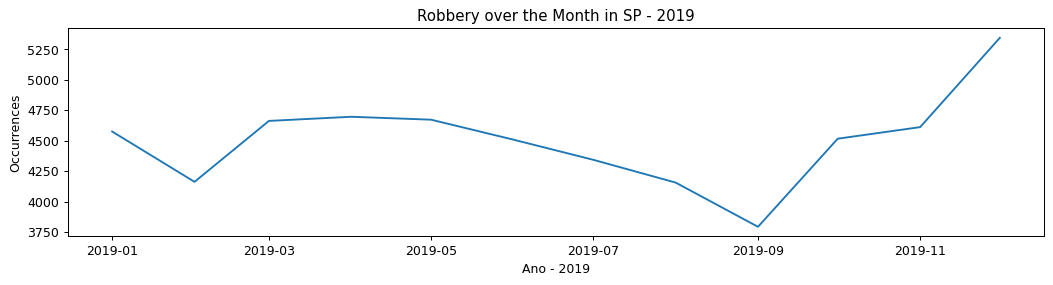

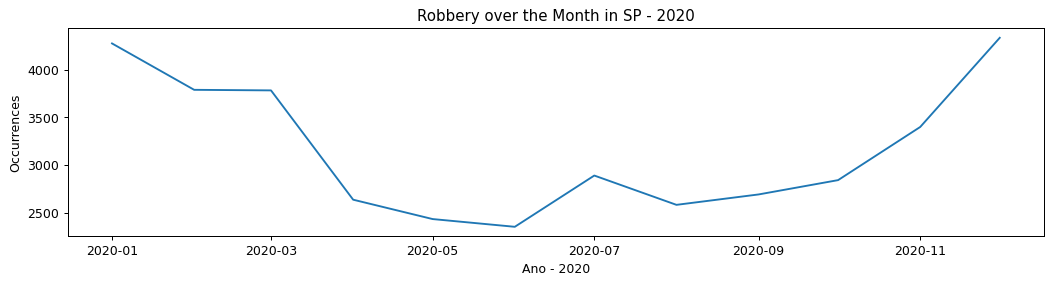

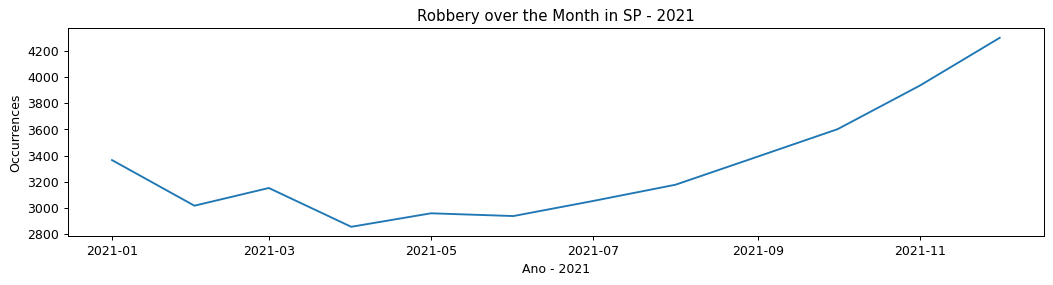

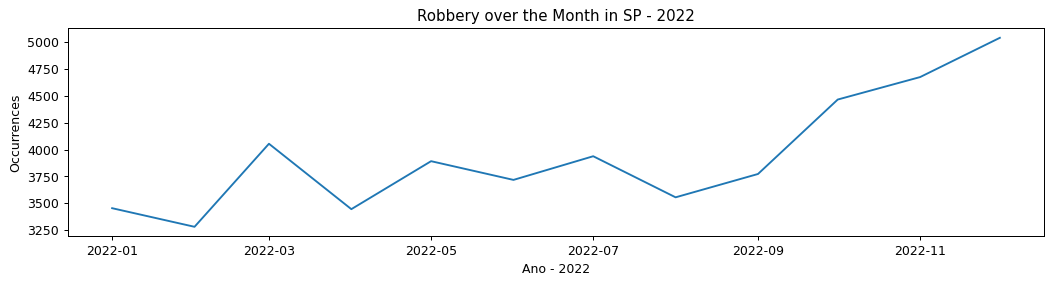

In [40]:
for year in grouped_df['Year'].unique():
  plot_dataset(grouped_df[grouped_df['Year'] == year].index,
              grouped_df[grouped_df['Year'] == year]['Occurrences'],
              f'Ano - {year}',
              'Occurrences',
              f'Robbery over the Month in SP - {year}', figsize=(14,3), dpi=3)

## Dickey–Fuller test

In [34]:
def check_stationarity(df):
  result = adfuller(df, autolag='AIC')

  print('-- Dickey–Fuller test --')
  print('ADF Statistic: %f' % result[0])
  print('p-value: %f' % result[1])
  print('Critical values: ')
  for key, value in result[4].items():
    print('\t%s: %3f' % (key, value))
  print('\n\n')

In [35]:
check_stationarity(grouped_df['Occurrences'])

-- Dickey–Fuller test --
ADF Statistic: -1.382072
p-value: 0.590840
Critical values: 
	1%: -3.511712
	5%: -2.897048
	10%: -2.585713





## Separating the time series into two groups and calculating the mean and variance of each.

In [36]:
def mean_variance(df):
  middle =  int(len(df) / 2)

  part_1, part_2 = df.head(middle), df.tail(middle)
  mean1, mean2 = part_1.mean(), part_2.mean()
  var1, var2 = part_1.var(), part_2.var()
  print('\n-- MEAN and VARIANCE --')
  print('Average of set 1: %f, Average of set 2: %f' % (mean1, mean2))
  print('variance of set 1: %f, Variance of set 2: %f\n' % (var1, var2))

In [37]:
mean_variance(grouped_df['Occurrences'])


-- MEAN and VARIANCE --
Average of set 1: 6717.291667, Average of set 2: 3731.562500
variance of set 1: 790520.721631, Variance of set 2: 555575.400266



## Autocorrelation

In [38]:
def plot_autocorrelation(value, lags=1):
  plot_acf(value, lags=lags)
  plot_pacf(value, lags=lags, method = "ols")
  plt.show()

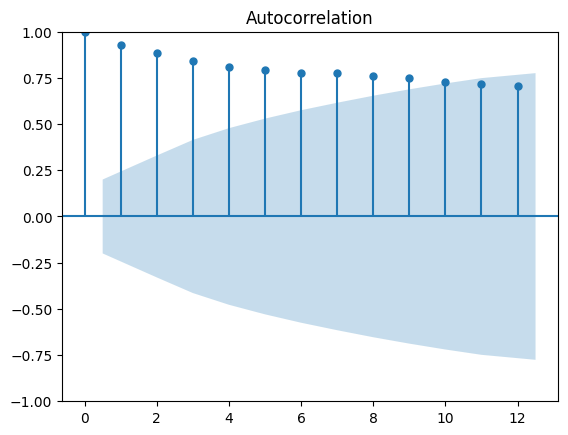

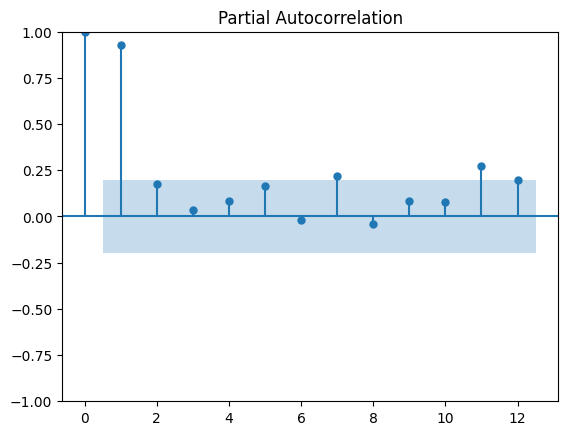

In [39]:
plot_autocorrelation(grouped_df['Occurrences'], lags=12)

# Plots
# Stationarity
# Correlation
# Encode date and month
# Exog
# Predction